# Marketing Campaign Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Import Data

In [2]:
df_raw=pd.read_csv('train.csv',sep=';')
df_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df=df_raw.copy()

In [4]:
df.shape

(45211, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Data Processing

In [6]:
per_null=(df.isna().sum()/df.shape[0])*100
per_null

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
y            0.0
dtype: float64

### Test for P-Value and Correlation

In [7]:
columns=df.columns
columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [8]:
for col in columns:
    print(f"\033[1m{col} \n{20 * '-'}\033[0m")
    print(f"\033[1m Unique :{df[col].nunique()}\n{20 * '-'}\033[0m")
    print(f"{20 * '-'}")
    print(df[col].value_counts(), '\n')

age 
--------------------
 Unique :77
--------------------
--------------------
32    2085
31    1996
33    1972
34    1930
35    1894
      ... 
93       2
90       2
95       2
88       2
94       1
Name: age, Length: 77, dtype: int64 

job 
--------------------
 Unique :12
--------------------
--------------------
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64 

marital 
--------------------
 Unique :3
--------------------
--------------------
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64 

education 
--------------------
 Unique :4
--------------------
--------------------
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64 

default 
--------------------
 

#### Ordinal and Binary category Encoding

In [9]:
df['education']=df['education'].map({'unknown':0,'primary':1,'secondary':2,'tertiary':3})

In [10]:
df['education'].value_counts()

2    23202
3    13301
1     6851
0     1857
Name: education, dtype: int64

In [11]:
df['default']=df['default'].map({'no':0,'yes':1})

In [12]:
df['default'].unique()

array([0, 1], dtype=int64)

In [13]:
df['housing']=df['housing'].map({'no':0,'yes':1})

In [14]:
df['housing'].unique()

array([1, 0], dtype=int64)

In [15]:
df['loan']=df['loan'].map({'no':0,'yes':1})

In [16]:
df['loan'].unique()

array([0, 1], dtype=int64)

In [17]:
df.drop('day',axis=1,inplace=True)
#last contact day of the month is not of use in this case

In [18]:
df['y_no']=df['y'].map({'no':0,'yes':1})

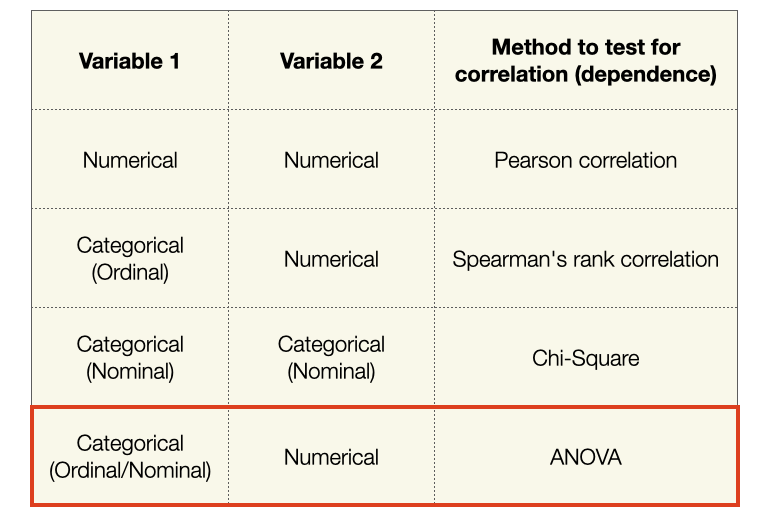

In [19]:
numeric = []
for label,content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        numeric.append(label)
numeric

['age',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'y_no']

In [20]:
#Find the number of non-numeric columns 
not_numeric=[]
for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        not_numeric.append(label)
not_numeric

['job', 'marital', 'contact', 'month', 'poutcome', 'y']

### Chi-Square Test 

In [21]:
from scipy.stats import chi2_contingency

In [22]:
# category=not_numeric[:-1]
X_cat=not_numeric[:-1]
y_cat=not_numeric[-1:]

In [23]:
pvalCat=[]
for col in X_cat:
    CrosstabResult=pd.crosstab(index=df[col],columns=df['y'])
    #print(CrosstabResult)    

    # Performing Chi-sq test
    ChiSqResult = chi2_contingency(CrosstabResult)
    pvalCat.append(ChiSqResult[1])

    # P-Value is the Probability of H0 being True
    # If P-Value&gt;0.05 then only we Accept the assumption(H0)\
    #print('The P-Value of the ChiSq Test is:', ChiSqResult[1]))

dict={'P-Value of the ChiSq Test':pvalCat}
PvalueTable=pd.DataFrame(dict,index=X_cat)
PvalueTable

,P-Value of the ChiSq Test
job,3.337122e-172
marital,2.145100e-43
contact,1.251738e-225
month,0.000000e+00
poutcome,0.000000e+00


#### All categorical features are significant variables because the P-Value < 0.05.

#### H0: The variables are not correlated with each other. This is the H0 used in the Chi-square test.

#### If the P-value came higher than 0.05. H0 will be accepted. Which means the variables are not correlated with each other.

#### This means, if two variables are correlated, then the P-value will come very close to zero.

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

### ANOVA Test

In [24]:
X_num=numeric[:-1]

In [25]:
from scipy.stats import f_oneway

In [26]:
pvalNum=[]
for col in X_num:
    # Running the one-way anova test between CarPrice and FuelTypes
    # Assumption(H0) is that FuelType and CarPrices are NOT correlated

    # Finds out the Prices data for each FuelType as a list
    CategoryGroupLists=df.groupby('y')[col].apply(list)
    #print(CategoryGroupLists)

    # Performing the ANOVA test
    # We accept the Assumption(H0) only when P-Value &gt; 0.05
    AnovaResults = f_oneway(*CategoryGroupLists)
    pvalNum.append(AnovaResults[1])
    #print('P-Value for Anova is: ', AnovaResults[1])

dict={'P-Value of the ChiSq Test':pvalNum}
PvalueTable=pd.DataFrame(dict,index=X_num)
PvalueTable

,P-Value of the ChiSq Test
age,8.825644e-08
education,8.905390e-28
default,1.866327e-06
balance,2.521114e-29
housing,2.621927e-194
loan,9.793658e-48
duration,0.000000e+00
campaign,1.012347e-54
pdays,3.790553e-108
previous,7.801830e-88


#### As the output of the P-value is almost zero, hence, we reject H0. Which means the variables are correlated with each other.

#### This means, if two variables are correlated, then the P-value will come very close to zero.

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

### Pearson Correlation

<AxesSubplot:>

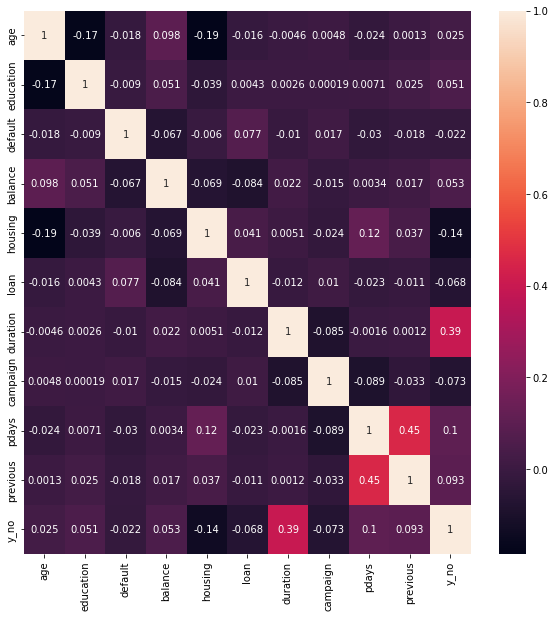

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(method ='pearson'),annot=True)

In [28]:
df_numeric=df[numeric]

In [29]:
df_numeric.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,y_no
0,58,3,0,2143,1,0,261,1,-1,0,0
1,44,2,0,29,1,0,151,1,-1,0,0
2,33,2,0,2,1,1,76,1,-1,0,0
3,47,0,0,1506,1,0,92,1,-1,0,0
4,33,0,0,1,0,0,198,1,-1,0,0


### Multi Colinearity

**One should always be concerned about the collinearity, regardless of the model/method being linear or not, or the main task being prediction or classification**

In [30]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [31]:
df_numeric.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,y_no
0,58,3,0,2143,1,0,261,1,-1,0,0
1,44,2,0,29,1,0,151,1,-1,0,0
2,33,2,0,2,1,1,76,1,-1,0,0
3,47,0,0,1506,1,0,92,1,-1,0,0
4,33,0,0,1,0,0,198,1,-1,0,0


In [32]:
calc_vif(df_numeric[:-1])

,variables,VIF
0,age,6.027195
1,education,5.352771
2,default,1.028075
3,balance,1.234682
4,housing,2.155287
5,loan,1.206611
6,duration,2.332575
7,campaign,1.770473
8,pdays,1.505570
9,previous,1.346348


#### VIF starts at 1 and has no upper limit
#### VIF = 1, no correlation between the independent variable and the other variables
#### VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

#### Multi Colinearity (Another method to check)

In [33]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix =df.corr().abs()
corr_matrix.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,y_no
age,1.000000,0.173615,0.017879,0.097783,0.185513,0.015655,0.004648,0.004760,0.023758,0.001288,0.025155
education,0.173615,1.000000,0.009035,0.050572,0.038689,0.004307,0.002554,0.000194,0.007092,0.025295,0.051341
default,0.017879,0.009035,1.000000,0.066745,0.006025,0.077234,0.010021,0.016822,0.029979,0.018329,0.022419
balance,0.097783,0.050572,0.066745,1.000000,0.068768,0.084350,0.021560,0.014578,0.003435,0.016674,0.052838
housing,0.185513,0.038689,0.006025,0.068768,1.000000,0.041323,0.005075,0.023599,0.124178,0.037076,0.139173


In [34]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,y_no
age,NaN,0.173615,0.017879,0.097783,0.185513,0.015655,0.004648,0.004760,0.023758,0.001288,0.025155
education,NaN,NaN,0.009035,0.050572,0.038689,0.004307,0.002554,0.000194,0.007092,0.025295,0.051341
default,NaN,NaN,NaN,0.066745,0.006025,0.077234,0.010021,0.016822,0.029979,0.018329,0.022419
balance,NaN,NaN,NaN,NaN,0.068768,0.084350,0.021560,0.014578,0.003435,0.016674,0.052838
housing,NaN,NaN,NaN,NaN,NaN,0.041323,0.005075,0.023599,0.124178,0.037076,0.139173


In [35]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 0 columns to remove.


### Nominal Encoding

#### Job

In [36]:
df['job'].nunique()

12

In [37]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

### When to Use Label Encoding vs. One Hot Encoding

**In most scenarios, one hot encoding is the preferred way to convert a categorical variable into a numeric variable because label encoding makes it seem that there is a ranking between values.**

**The label encoded data makes it seem like team C is somehow greater or larger than teams B and A since it has a higher numeric value.**

**This isn’t an issue if the original categorical variable actually is an ordinal variable with a natural ordering or ranking, but in many scenarios this isn’t the case.**

**However, one drawback of one hot encoding is that it requires you to make as many new variables as there are unique values in the original categorical variable.**

**This means that if your categorical variable has 100 unique values, you’ll have to create 100 new variables when using one hot encoding.**

**Depending on the size of your dataset and the type of variables you’re working with, you may prefer one hot encoding or label encoding.**

In [38]:
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [39]:
job=pd.get_dummies(df['job'],drop_first=True)

In [40]:
df=pd.concat([df,job],axis=1)

In [41]:
df.drop('job',axis=1,inplace=True)

#### marital

In [42]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [43]:
marital=pd.get_dummies(df['marital'],drop_first=True)

In [44]:
df=pd.concat([df,marital],axis=1)

In [45]:
df.drop('marital',axis=1,inplace=True)

#### contact

In [46]:
df['contact'].unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [47]:
df.drop('contact',axis=1,inplace=True)

#### Month

In [48]:
df['month']=df['month'].map({'dec':12, 'jan':1, 'oct':10, 'jun':6, 'feb':2, 'nov':11, 'apr':4, 'mar':3, 'aug':8,
       'jul':7, 'may':5, 'sep':9})

In [49]:
df['month'].unique()

array([ 5,  6,  7,  8, 10, 11, 12,  1,  2,  3,  4,  9], dtype=int64)

#### Poutcome

In [50]:
df['poutcome'].unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [51]:
poutcome=pd.get_dummies(df['poutcome'],drop_first=True)

In [52]:
df=pd.concat([df,poutcome],axis=1)

In [53]:
df.drop(['poutcome','y'],axis=1,inplace=True)

## EDA

In [54]:
numeric_new=[]
for label,content in df_raw.items():
    if pd.api.types.is_numeric_dtype(content):
        numeric_new.append(label)
numeric_new

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [55]:
numericdf=df_raw[numeric_new]

In [56]:
numericdf.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


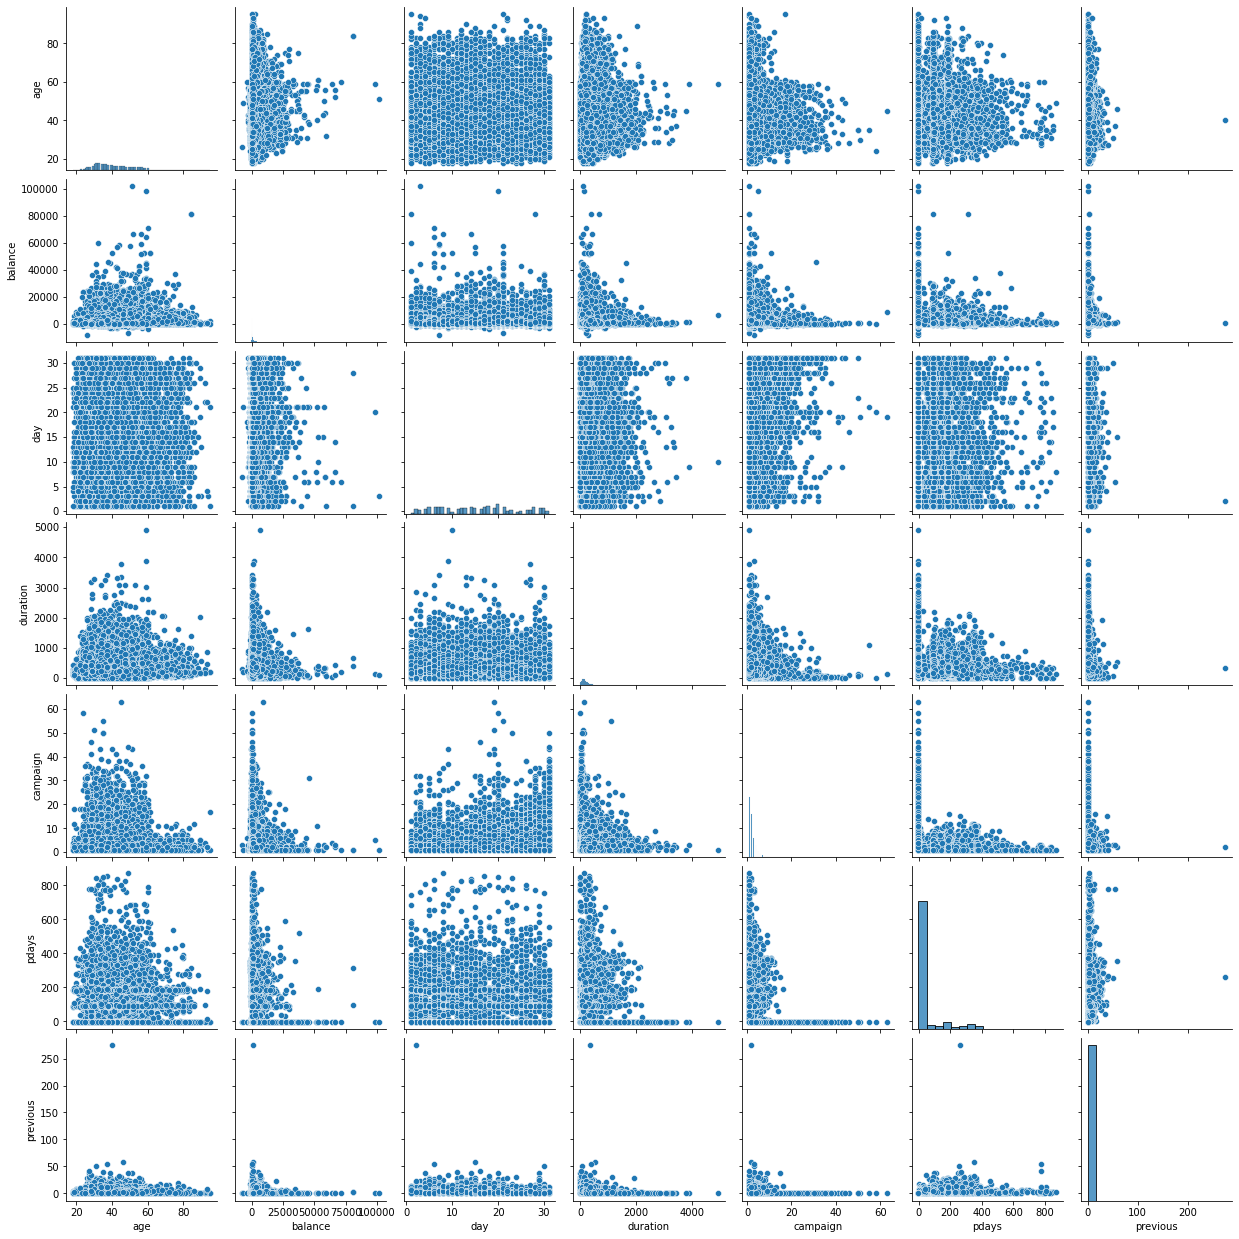

In [57]:
sns.pairplot(numericdf, markers=["o", "s", "D"])

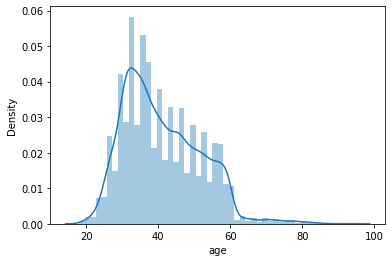

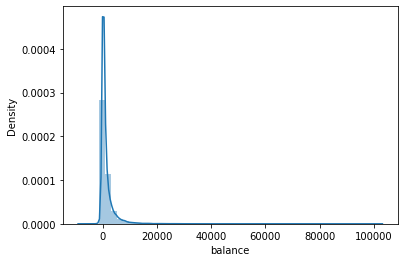

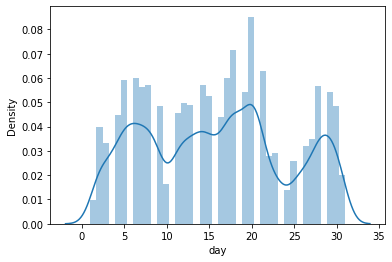

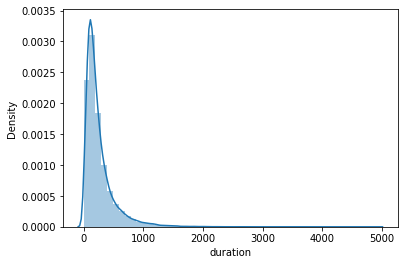

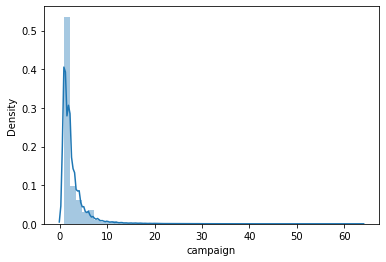

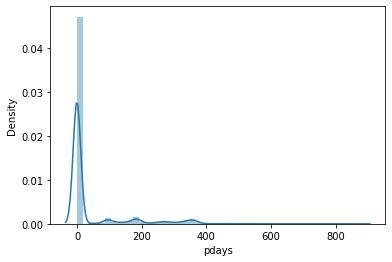

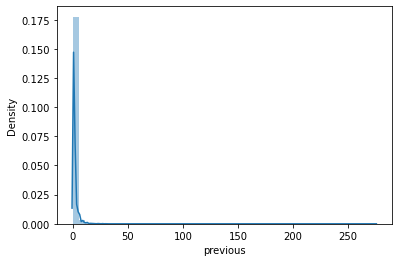

In [58]:
for i in numericdf.columns:
    sns.distplot(numericdf[i])
    plt.show()

In [59]:
not_numeric_new=[]
for label,content in df_raw.items():
    if not pd.api.types.is_numeric_dtype(content):
        not_numeric_new.append(label)
not_numeric_new

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [60]:
nonnumericdf=df_raw[not_numeric_new]
nonnumericdf.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no


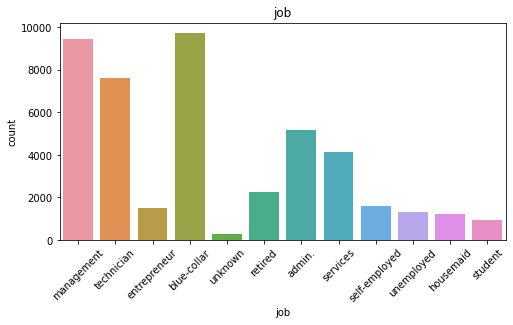

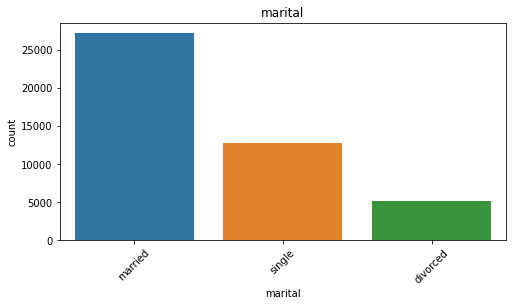

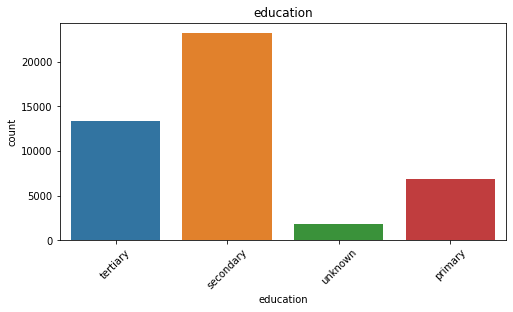

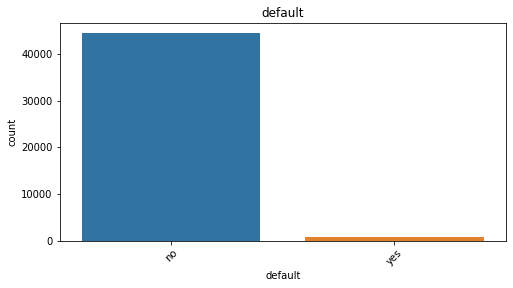

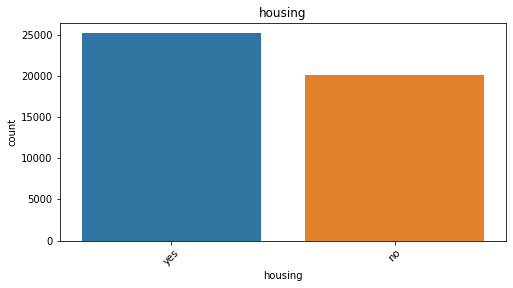

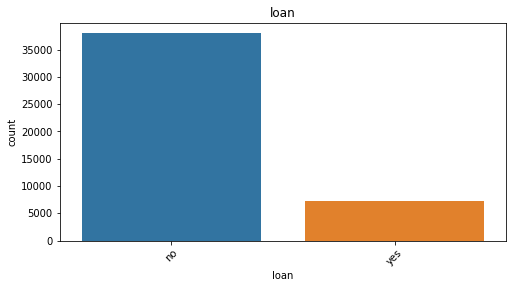

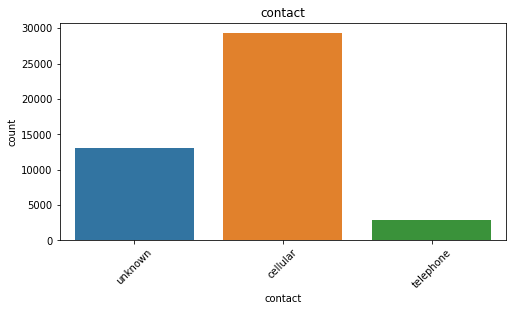

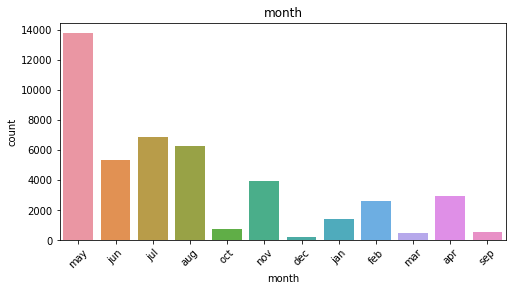

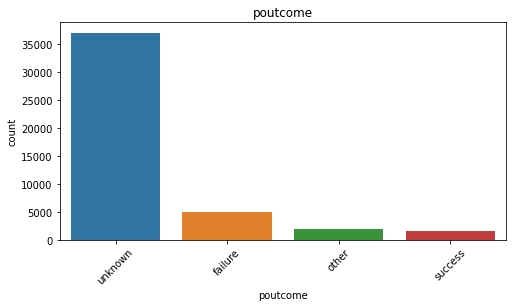

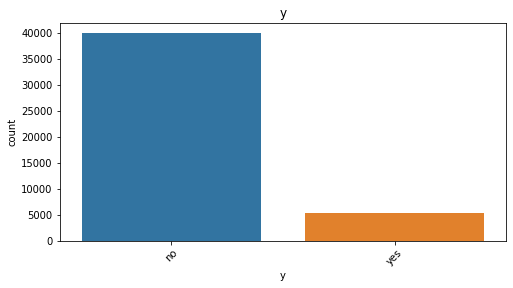

In [61]:
for col in not_numeric_new:
    plt.figure(figsize=(8,4))
    sns.countplot(x=nonnumericdf[col], data=nonnumericdf)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

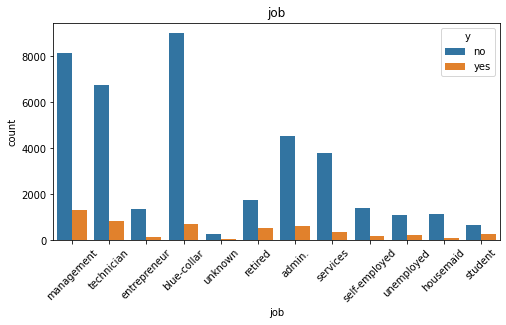

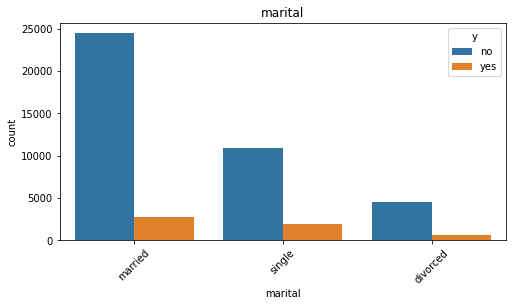

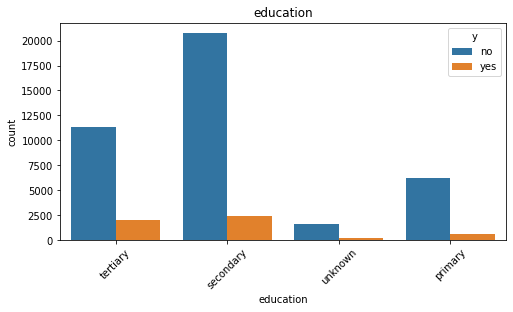

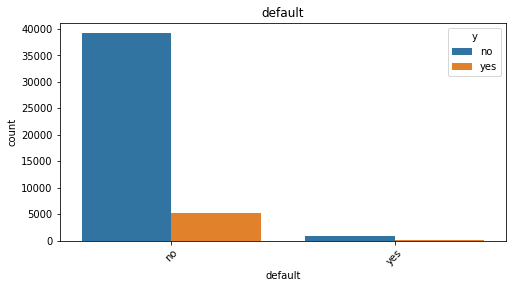

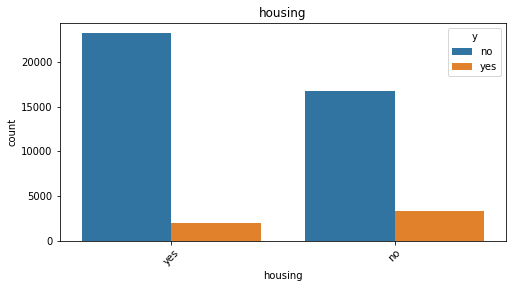

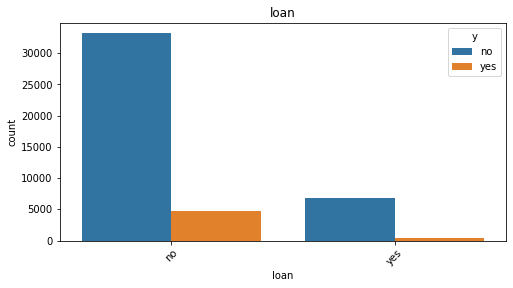

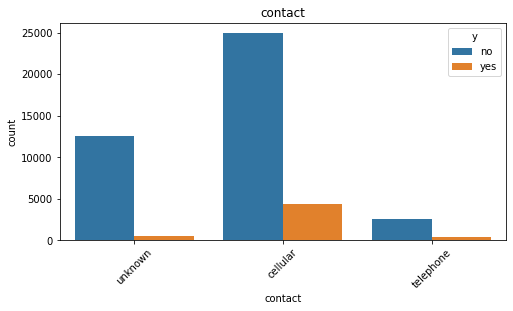

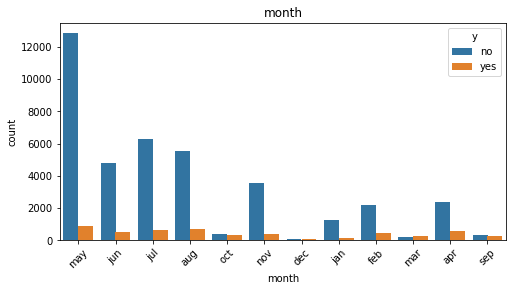

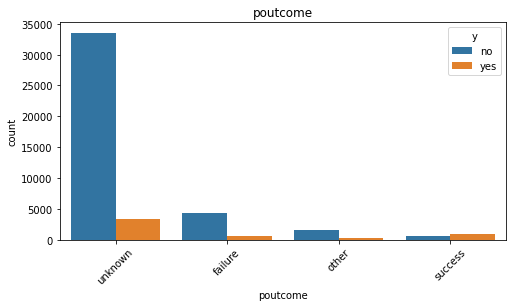

In [62]:
for col in not_numeric_new[:-1]:
    plt.figure(figsize=(8,4))
    sns.countplot(x=nonnumericdf[col], data=nonnumericdf,hue='y')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

<AxesSubplot:xlabel='y_no', ylabel='count'>

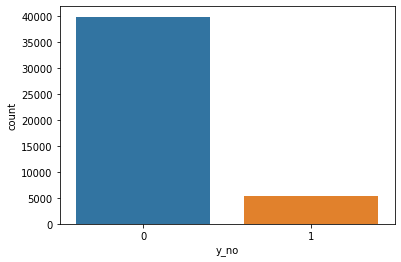

In [63]:
sns.countplot(x=df['y_no'], data=df)

**Its an Imbalenced data set**

**Before Balencing the data we will check for Outliers**

## Outlier

In [64]:
from scipy import stats

In [65]:
df.shape

(45211, 28)

In [66]:
df_new=df[(np.abs(stats.zscore(df))<3).all(axis=1)]

In [67]:
df.shape

(45211, 28)

In [68]:
X=df.drop('y_no',axis=1)
y=df['y_no']

## Train Test Split

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Balencing Data

### Resampling

## SMOTETomek

In [71]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all')
X_train, y_train = smt.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='y_no', ylabel='count'>

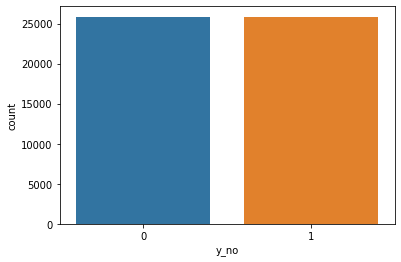

In [72]:
sns.countplot(y_train)

<AxesSubplot:xlabel='y_no', ylabel='count'>

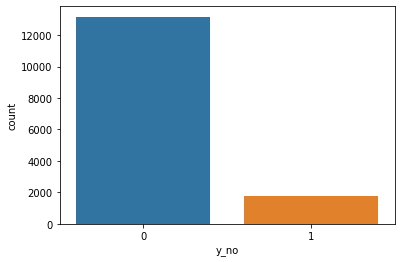

In [73]:
sns.countplot(y_test)

## Standard Scalar

In [74]:
from sklearn.preprocessing import MinMaxScaler

In [75]:
sc=MinMaxScaler(feature_range=(0, 1))

In [76]:
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

## Saving Data in Pickle

In [77]:
import pickle

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()